# ReAct(Reasoning and Acting) Simple
- Prebuilt ReAct Agent( https://langchain-ai.github.io/langgraph/how-tos/#prebuilt-react-agent )
  - `LangGraph`ではあらかじめ`ReAct Agent`用にコンパイルされたグラフが`prebuild`として用意されている。
    - 手動で実装する例: How to create a ReAct agent from scratch( https://langchain-ai.github.io/langgraph/how-tos/react-agent-from-scratch/ )
    - 独自のノードとかを追加したい場合はこれを利用するのがよさそう
  - How to use the pre-built ReAct agent( https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/ )
- LangGraphを用いたAIエージェント"ReAct"の実装( https://qiita.com/t_serizawa/items/0810a2b05c099c08105e )


(参考)
- langchain-ai/react-agent( https://github.com/langchain-ai/react-agent )

## パッケージインストール

In [40]:
%pip install -qU langgraph langchain-openai


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## 環境変数読み込み

In [41]:
from dotenv import load_dotenv
import os

load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_PROJECT"] = "langchain-rag"

## モデルの用意

In [42]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## ツールの用意
`@tool`というデコレーターを用いることでAgentに使用させるツールを定義  
関数の定義と合わせてLLMに対するツールの説明を記載する。

- `Tools`( https://python.langchain.com/docs/concepts/tools/ )

ここではダミー関数として2つの関数を実装している。

In [43]:
from typing import Literal
from langchain_core.tools import tool

@tool
def get_weather(city: Literal["tokyo", "Hokkaido"]) -> str:
    """天候に関する情報を取得するツール"""
    
    if city == "tokyo":
        return "東京の天気は晴れです。"
    elif city == "Hokkaido":
        return "北海道の天気は曇りです。"
    else:
        raise AssertionError("Unknown city")

@tool
def search_restaurant(dish: str) -> str:
    """レストランに関する情報を取得するツール"""
    if dish == "ハンバーガー":
        return "マクドナルド。"
    elif dish == "ラーメン":
        return "二郎。"
    else:
        raise AssertionError("Unknown dish")

tools = [get_weather, search_restaurant]

## グラフの定義
`create_react_agent()`を使用してグラフを作成することで、`ReAct`に沿ったグラフを作成できる。  
`prebuilt`パッケージに含まれているのでグラフのコンパイルは不要。

- `create_react_agent()`( https://langchain-ai.github.io/langgraph/reference/prebuilt/#langgraph.prebuilt.chat_agent_executor.create_react_agent )

In [44]:
from langgraph.prebuilt import create_react_agent

graph = create_react_agent(model, tools=tools)
# graph = create_react_agent(model, tools=tools, response_format=tuple)  # tupleで結果を取得

## 実行

In [ ]:
# inputs = {"messages": [("user", "東京の天気は？")]}         # get_weather()が呼び出される
# inputs = {"messages": [("user", "ラーメンが食べたいな。")]}  # search_restaurant()が呼び出される

inputs = {"messages": [("user", "東京でラーメンが食べたいな。天気も心配だ。")]}  # get_weather()とsearch_restaurant()が呼び出される

result=graph.invoke(inputs)

print("=== 全てのメッセージを表示 ===")
for message in result["messages"]:
    print(f"{message.__class__.__name__}: {message}")

print("=== 最終的な回答のみを表示 ===")
print(result["messages"][-1].content)

=== 全てのメッセージを表示 ===
HumanMessage: content='東京でラーメンが食べたいな。天気も心配だ。' additional_kwargs={} response_metadata={} id='80884a28-8cb1-4fe2-bf3c-7234c7df6daa'
AIMessage: content='' additional_kwargs={'tool_calls': [{'id': 'call_brOIvx89Sr0FmITIJLAy1rNF', 'function': {'arguments': '{"dish": "ラーメン"}', 'name': 'search_restaurant'}, 'type': 'function'}, {'id': 'call_8WCROh6lb4P7s7F9mm8wSwvD', 'function': {'arguments': '{"city": "tokyo"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 50, 'prompt_tokens': 105, 'total_tokens': 155, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_86d0290411', 'id': 'chatcmpl-BJLq73T2EjoET8TuJ68I8WErNUhHk', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-54e5022f-de09-

## グラフの描画

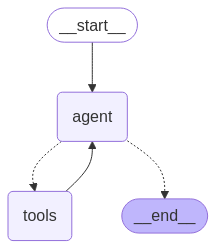

In [46]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))